### 1. Import data and revelant packages 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/My Drive/bt4222code'

In [3]:
df = pd.read_csv(path + '/combined.csv', index_col=0)
df.head()
df = df.reset_index(drop=True)

In [4]:
# Label Encoding 
df['street'] = df['street'].astype('category')
street_dict = dict(zip(df['street'], df['street'].cat.codes))
df['street'] = df['street'].cat.codes

df['propertyType'] = df['propertyType'].astype('category')
property_dict = dict(zip(df['propertyType'], df['propertyType'].cat.codes))
df['propertyType'] = df['propertyType'].cat.codes

df['floor_range'] = df['floor_range'].astype('category')
floor_dict = dict(zip(df['floor_range'], df['floor_range'].cat.codes))
df['floor_range'] = df['floor_range'].cat.codes

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1),
                                                    df['price'], 
                                                    test_size=0.1,
                                                    random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120321, 14)
(13369, 14)
(120321,)
(13369,)


### 2.MACHINE LEARNING

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

In [38]:
train_df.rename(columns={'Bus Stops Nearby':'busstop'}, inplace=True)
test_df.rename(columns={'Bus Stops Nearby':'busstop'}, inplace=True)

In [14]:
train_df

,district,street,propertyType,remaining_lease,school,hawkercentre,supermarkets,busstop,crime_number,latitude,longitude,floor_area_sqm,floor_range,sentiment,price
3202,3,1664,6,-0.029144,24,16,7,0,1.188938,1.295995,103.803682,-0.051672,5,0.061551,1410000.0
43222,18,1374,4,-0.030327,26,4,14,0,0.684523,1.373332,103.956317,0.082468,1,0.066871,465000.0
49910,23,292,3,-0.030356,24,1,11,0,0.780019,1.383134,103.744511,-0.129920,3,0.082581,405000.0
133687,27,1985,8,-0.031322,18,2,19,0,-1.027059,1.424340,103.845070,0.350748,1,0.102094,607000.0
60467,16,251,2,-0.031468,24,12,13,1,0.104201,1.325868,103.919346,-0.431735,2,0.086985,310000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73349,27,229,8,-0.029057,18,2,19,0,-1.027059,1.446988,103.822728,0.317213,1,0.050351,543000.0
109259,20,30,2,-0.033054,37,11,5,0,-0.020678,1.366667,103.835554,-0.465270,1,0.138476,330000.0
50057,19,656,3,-0.028985,45,5,16,0,1.340752,1.377131,103.884482,-0.241703,1,0.168686,330000.0
5192,11,573,7,0.130220,51,1,6,0,-2.141179,1.332608,103.805469,4.259806,0,0.323895,7900000.0


In [39]:
transformed_test_df = test_df
transformed_train_df = train_df

In [40]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Get the range of latitudes
step_lat = max(transformed_train_df['latitude']) - min(transformed_train_df['latitude'])

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(min(transformed_train_df['latitude']), 
                                     max(transformed_train_df['latitude']), 
                                     step_lat / 10.0))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)

# Get the range of longitude
step_lgn = max(transformed_train_df['longitude']) - min(transformed_train_df['longitude'])

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(min(transformed_train_df['longitude']), 
                                      max(transformed_train_df['longitude']), 
                                      step_lgn / 10.0))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], 
                                                        hash_bucket_size=100)

crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

ls = ['district',	'street',	'propertyType',	'remaining_lease',	'school',	'hawkercentre',	'supermarkets',	'busstop',	'crime_number',	'floor_area_sqm',	'floor_range', 'sentiment']

for i in ls:
  feature_columns.append(tf.feature_column.numeric_column(i))

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [41]:
#@title Define the plotting function.

def plot_the_loss_curve(mse_train, mse_val):
  """Plot a curve of loss vs. epoch."""

  plt.figure(figsize=(10, 8))
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(mse_train, label="Training Loss")
  plt.plot(mse_val, label="Validation Loss")
  plt.legend()
  # plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

In [42]:
#@title Define functions to create and train a linear regression model
def create_model_linear(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""

  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error", 
                metrics=[tf.keras.metrics.MeanSquaredError()])
  return model           

In [43]:
def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=0.2, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  mse_train = history.history['loss']
  mse_val = history.history['val_loss']

  return mse_train, mse_val

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
358/376 [===========================>..] - ETA: 0s - loss: 3587894669014.5249 - mean_squared_error: 3587894669014.5249WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'district': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, 'street': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=int16>, 'propertyType': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int8>, 'remaining_lease': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float32>, 'school': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'hawkercentre': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'supermarkets': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=int64>, 'busstop': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'crime_number': <tf.Tensor 'ExpandDims_1:0' shape=(None, 

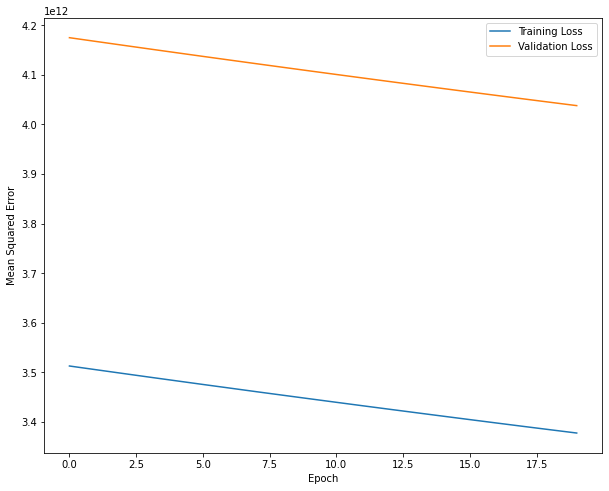

In [44]:
# The following variables are the hyperparameters.
learning_rate = 0.01
number_epochs = 20
batch_size = 256
label_name = "price"

# Establish the model's topography.
model_lr = create_model_linear(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
mse_train_lr, mse_val_lr = train_model(model_lr, transformed_train_df, number_epochs, batch_size, label_name)
plot_the_loss_curve(mse_train_lr, mse_val_lr)

In [45]:
test_features = {name:np.array(value) for name, value in transformed_test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label

print("\n Evaluate the linear regression model against the test set:")
result = model_lr.evaluate(x=test_features, y=test_label, batch_size=batch_size)

for item in zip(model_lr.metrics_names, result):
  print (item[0], item[1])


 Evaluate the linear regression model against the test set:
53/53 [==============================] - 0s 2ms/step - loss: 2941453336576.0000 - mean_squared_error: 2941453336576.0000
loss 2941453336576.0
mean_squared_error 2941453336576.0


In [46]:
model_lr.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_1 (DenseFeatu multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  113       
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [47]:
def create_model_deep(my_learning_rate, my_feature_layer, layers=[20, 12]):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the hidden layers
  for index, layer in enumerate(layers):
    model.add(tf.keras.layers.Dense(units=layer, 
                                    activation='relu', 
                                    name=f'Hidden{index}'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1, name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])
  return model

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
367/376 [============================>.] - ETA: 0s - loss: 3329448316671.3022 - mean_squared_error: 3329448316671.3022WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'district': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, 'street': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=int16>, 'propertyType': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int8>, 'remaining_lease': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float32>, 'school': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'hawkercentre': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'supermarkets': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=int64>, 'busstop': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'crime_number': <tf.Tensor 'ExpandDims_1:0' shape=(None, 

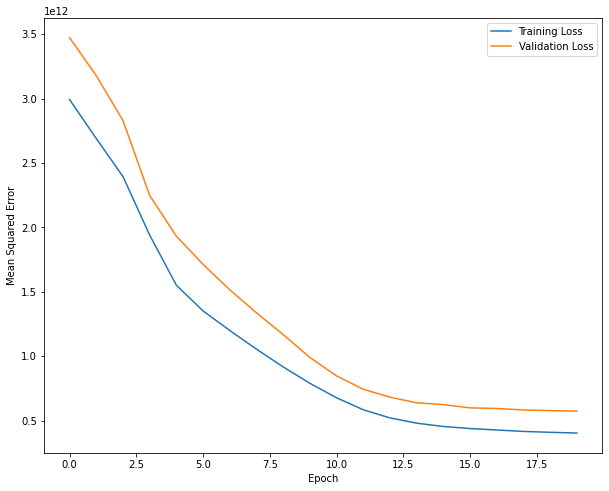

In [48]:
# The following variables are the hyperparameters.
learning_rate = 0.01

# Specify the label
label_name = "price"

# Establish the model's topography.
model_deep = create_model_deep(learning_rate, my_feature_layer, [20, 12])
# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.

number_epochs = 20

mse_train_deep, mse_val_deep = train_model(model_deep, transformed_train_df, number_epochs, batch_size, label_name)
plot_the_loss_curve(mse_train_deep, mse_val_deep)

In [49]:
# After building a model against the training set, test that model
# against the test set.
result = model_deep.evaluate(x=test_features, 
                  y=test_label, 
                  batch_size=batch_size)

for item in zip(model_deep.metrics_names, result):
  print (item[0], item[1])

53/53 [==============================] - 0s 2ms/step - loss: 343065788416.0000 - mean_squared_error: 343065788416.0000
loss 343065788416.0
mean_squared_error 343065788416.0


In [50]:
model_deep.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_1 (DenseFeatu multiple                  0         
_________________________________________________________________
Hidden0 (Dense)              multiple                  2260      
_________________________________________________________________
Hidden1 (Dense)              multiple                  252       
_________________________________________________________________
Output (Dense)               multiple                  13        
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________


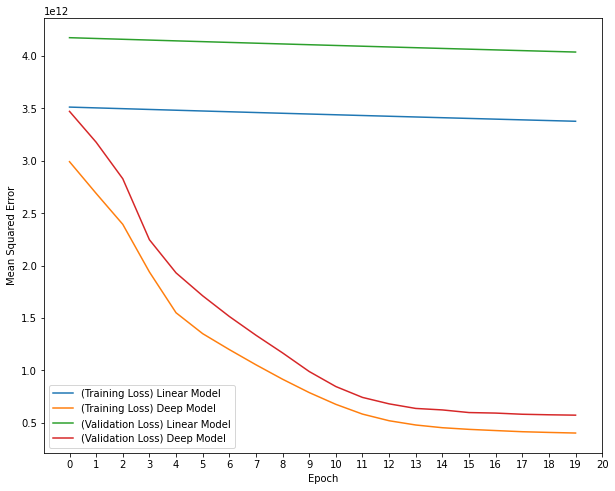

In [51]:
plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(mse_train_lr, label="(Training Loss) Linear Model")
plt.plot(mse_train_deep, label="(Training Loss) Deep Model")
plt.plot(mse_val_lr, label="(Validation Loss) Linear Model")
plt.plot(mse_val_deep, label="(Validation Loss) Deep Model")
plt.legend()
# plt.ylim([mse.min()*0.95, mse.max() * 1.03])
plt.xticks(range(21))
plt.show() 

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
369/376 [============================>.] - ETA: 0s - loss: 3374749861216.4336 - mean_squared_error: 3374749861216.4336WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'district': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, 'street': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=int16>, 'propertyType': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int8>, 'remaining_lease': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float32>, 'school': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'hawkercentre': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'supermarkets': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=int64>, 'busstop': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'crime_number': <tf.Tensor 'ExpandDims_1:0' shape=(None, 

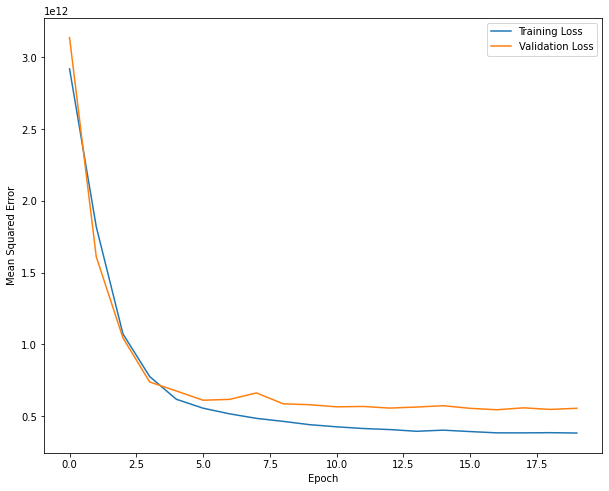

In [52]:
# Establish the model's topography.
model_deep_better = create_model_deep(learning_rate, my_feature_layer, [30, 20, 10, 8])

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.

mse_train_deep1, mse_val_deep1 = train_model(model_deep_better, transformed_train_df, number_epochs, batch_size, label_name)
plot_the_loss_curve(mse_train_deep1, mse_val_deep1)


In [53]:
result = model_deep_better.evaluate(x=test_features, 
                  y=test_label, 
                  batch_size=batch_size)

for item in zip(model_deep.metrics_names, result):
  print (item[0], item[1])

53/53 [==============================] - 0s 2ms/step - loss: 344684331008.0000 - mean_squared_error: 344684331008.0000
loss 344684331008.0
mean_squared_error 344684331008.0


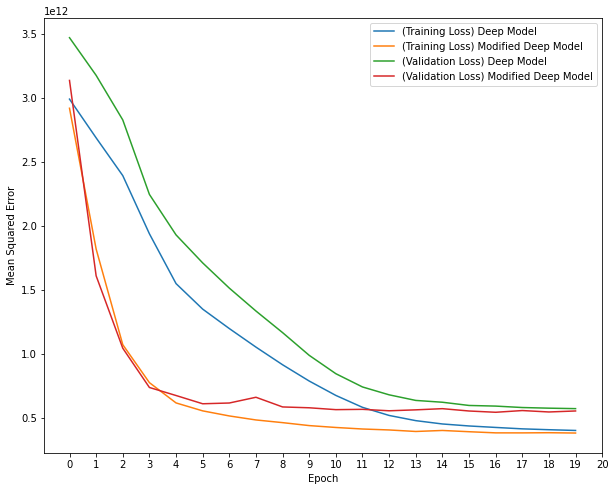

In [54]:
plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(mse_train_deep, label="(Training Loss) Deep Model")
plt.plot(mse_train_deep1, label="(Training Loss) Modified Deep Model")
plt.plot(mse_val_deep, label="(Validation Loss) Deep Model")
plt.plot(mse_val_deep1, label="(Validation Loss) Modified Deep Model")
plt.legend()
# plt.ylim([mse.min()*0.95, mse.max() * 1.03])
plt.xticks(range(21))
plt.show() 

In [62]:
# Use L2 Regularization

def create_model_deep_L2(my_learning_rate, my_feature_layer, layers=[20, 12], C=0.04):
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the hidden layers
  for index, layer in enumerate(layers):
    model.add(tf.keras.layers.Dense(units=layer, 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(C),
                                    name=f'Hidden{index}'))  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])
  return model

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
374/376 [============================>.] - ETA: 0s - loss: 2999565579707.5508 - mean_squared_error: 2999565579707.5508 - mean_absolute_percentage_error: 93.0554WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'district': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, 'street': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=int16>, 'propertyType': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int8>, 'remaining_lease': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float32>, 'school': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int64>, 'hawkercentre': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'supermarkets': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=int64>, 'busstop': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'crime_number':

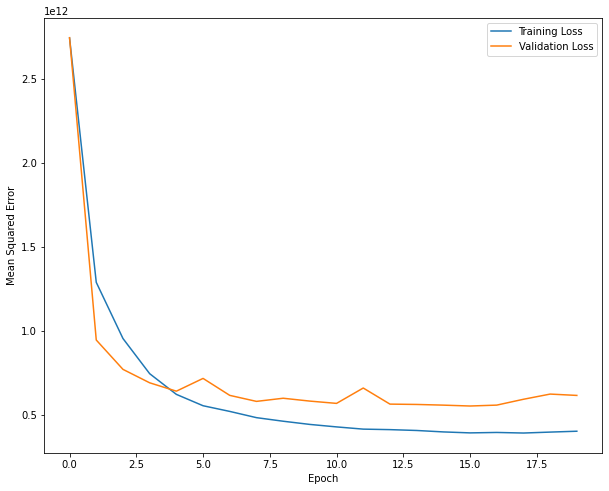

In [63]:
# Call the new create_model function and the other (unchanged) functions.

# The following variables are the hyperparameters.
label_name = "price"

# Establish the model's topography.
model_reg = create_model_deep_L2(learning_rate, my_feature_layer, [20, 10, 10, 8], C=0.001)

# Train the model on the normalized training set.
mse_train_reg, mse_val_reg = train_model(model_reg, transformed_train_df, number_epochs, batch_size, label_name)
plot_the_loss_curve(mse_train_reg, mse_val_reg)

In [64]:
result = model_reg.evaluate(x=test_features, 
                  y=test_label, 
                  batch_size=batch_size)

for item in zip(model_reg.metrics_names, result):
  print (item[0], item[1])

53/53 [==============================] - 0s 2ms/step - loss: 410770767872.0000 - mean_squared_error: 410770767872.0000 - mean_absolute_percentage_error: 24.3460
loss 410770767872.0
mean_squared_error 410770767872.0
mean_absolute_percentage_error 24.34595489501953
